*About this document*

This is the assignment for the UCL CASA module Data Science for Spatial Systems (CASA0006)
This is a self-contained Jupyter notebook with structure introduction, discussion and embeded code and bibliography.

*Data & Code is hosted [here](https://github.com/jianghan0v0/CASA006-coursework/tree/main)*

# Assessing Healthcare Accessibility and Inequality in California

# 1. Project Introduction
## 1.1 Introduction
In the wake of pressing challenges in public health management, equitable distribution of medical resources has emerged as a cornerstone of effective healthcare systems. This project seeks to explore the allocation of medical resources across California, delving into the socioeconomic underpinnings that drive this distribution. By leveraging a comprehensive database encompassing 153 variables from economic, social, and cultural domains, alongside detailed records from all clinics and hospitals, this research aims to paint a granular picture of healthcare provision and its intersection with societal inequities.

## 1.2 Aims
This research is designed to scrutinize the factors influencing the demand for medical services within California, aiming to forecast future utilization patterns and assess their implications for urban health management. In doing so, the study endeavors to evaluate the current state of California’s public health system and compile evidence crucial for its strategic assessment. Employing advanced regression and classification methods, such as Principal Component Analysis (PCA) for data dimensionality reduction, followed by Random Forest and Decision Tree models, the study aspires to predict the requisite number of medical facilities. By juxtaposing anticipated needs against the backdrop of existing data, the project aims to provide actionable insights for the development of medical resources in California, and, by extension, contribute to addressing the challenge of social inequality.

# 2. Data Prepration
## 2.1 Import Data

The journey into understanding healthcare accessibility began with the importation of critical datasets. Three distinct sources provided a multifaceted view: housing details, medical facility records, and geographic boundaries of counties represented by a shapefile. Each dataset was meticulously sourced from reliable repositories to ensure the integrity of the analysis that would follow.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
housing_data_path = 'https://github.com/jianghan0v0/CASA006-coursework/raw/main/dataset/housing.csv'
medical_data_path = 'https://github.com/jianghan0v0/CASA006-coursework/raw/main/dataset/Facility1.csv'
svi_data_2020_path = 'https://github.com/jianghan0v0/CASA006-coursework/raw/main/dataset/svi_2020.csv'
shapefile_path = 'https://github.com/jianghan0v0/CASA006-coursework/raw/main/dataset/ca_county_boundaries/ca_county_boundaries.shp'

housing_data = pd.read_csv(housing_data_path)
medical_data = pd.read_csv(medical_data_path)
svi_data_2020 = pd.read_csv(svi_data_2020_path)


## 2.2 Look Into Data

Here we will examine the first few rows of each dataset, look at column names and data types, and identify missing values and possibly unnecessary columns.

In [42]:
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.23,37.88,41,880,129.0,322,126,8.3252,452600
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200


In [43]:
medical_data.head()

,Facility_Name,City,ZIP_Code,County_Code,County_Name,Type,Category,longitude,latitude,x,y
0,BERKELEY THERAPY INSTITUTE,Berkeley,94709,1,Alameda,Clinic,Community Clinic,-122.273185,37.874755,-13611387.23,4561747.266
1,EAST OAKLAND HEALTH CENTER,Oakland,94621,1,Alameda,Clinic,Community Clinic,-122.185760,37.758600,-13601655.12,4545379.288
2,EASTER SEAL SOC OF THE BAY AREA,Oakland,94612,1,Alameda,Clinic,Community Clinic,-122.267910,37.816740,-13610800.02,4553568.865
3,AXIS COMMUNITY HEALTH,Pleasanton,94566,1,Alameda,Clinic,Community Clinic,-121.873710,37.661450,-13566917.88,4531709.125
4,LA CLINICA DE LA RAZA FRUITVALE HEALTH PROJECT,Oakland,94601,1,Alameda,Clinic,Community Clinic,-122.225150,37.778750,-13606040.00,4548216.880


In [44]:
svi_data_2020.head()

,COUNTY,FIPS,E_TOTPOP,M_TOTPOP,E_HU,M_HU,E_HH,M_HH,E_POV150,M_POV150,...,EP_ASIAN,MP_ASIAN,EP_AIAN,MP_AIAN,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE
0,Alameda County,6001,1661584,0,605767,422,573174,1395,233543,5366,...,31.0,0.1,0.3,0.1,0.8,0.1,4.6,0.2,0.4,0.1
1,Alpine County,6003,1159,172,1794,120,397,79,227,92,...,0.5,0.8,28.7,4.2,0.0,3.4,2.8,2.1,0.0,3.4
2,Amador County,6005,39023,0,18246,170,14844,451,5416,776,...,0.9,0.3,0.5,0.2,0.1,0.1,4.5,0.6,0.6,0.6
3,Butte County,6007,223344,0,93968,223,83879,885,63024,2406,...,4.6,0.2,0.8,0.1,0.2,0.1,4.5,0.4,0.1,0.1
4,Calaveras County,6009,45828,0,28096,63,16958,557,9067,1157,...,1.9,0.3,0.6,0.3,0.0,0.1,3.7,0.6,0.1,0.1


## 2.3 Data fusion


In [4]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Here we recognize the key words, like ZIP_code
# 加载Shapefile
gdf_counties = gpd.read_file('https://github.com/jianghan0v0/CASA006-coursework/raw/main/dataset/ca_county_boundaries/ca_county_boundaries.shp')


In [5]:
# 创建点对象
housing_data['geometry'] = [Point(xy) for xy in zip(housing_data.longitude, housing_data.latitude)]

# 将DataFrame转换为GeoDataFrame，并设置CRS
housing_geo = gpd.GeoDataFrame(housing_data, geometry='geometry')
housing_geo.set_crs(epsg=4326, inplace=True)  # 设置坐标参考系统为WGS84

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,geometry
0,-122.23,37.88,41,880,129.0,322,126,8.3252,452600,POINT (-122.23000 37.88000)
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500,POINT (-122.22000 37.86000)
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100,POINT (-122.24000 37.85000)
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300,POINT (-122.25000 37.85000)
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200,POINT (-122.25000 37.85000)
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25,1665,374.0,845,330,1.5603,78100,POINT (-121.09000 39.48000)
20636,-121.21,39.49,18,697,150.0,356,114,2.5568,77100,POINT (-121.21000 39.49000)
20637,-121.22,39.43,17,2254,485.0,1007,433,1.7000,92300,POINT (-121.22000 39.43000)
20638,-121.32,39.43,18,1860,409.0,741,349,1.8672,84700,POINT (-121.32000 39.43000)


The follow code proceeded with a spatial join, a technique pivotal in mapping each housing entity to its respective county. These were promptly addressed by transforming the COUNTYFP column to ensure a uniform format and reconciling CRS discrepancies.

In [6]:
# 执行空间连接，找到每个房屋点所在的县
housing_geo = gpd.sjoin(housing_geo, gdf_counties, how="left", op='within')

# 调整COUNTYFP格式，处理NaN值并确保为四位数
housing_geo['COUNTYFP'] = housing_geo['COUNTYFP'].fillna(0).astype(int).apply(lambda x: f"6{x:03}")

# 提取所有原始列和新增的COUNTYFP列
columns_to_keep = housing_data.columns.tolist() + ['COUNTYFP']
housing_final = housing_geo[columns_to_keep]


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-6-81c06ad6532d>:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:3857

  housing_geo = gpd.sjoin(housing_geo, gdf_counties, how="left", op='within')


In [7]:
# 按FIPS代码合并数据
# 保存到新的CSV文件
output_path = '/content/updated_housing_data.csv'
housing_final.to_csv(output_path, index=False)
##from google.colab import files
##files.download('/content/updated_housing_data.csv')

Merging datasets paved the way for an integrated view, aligning housing characteristics with medical data against the backdrop of social vulnerability indicators. Potential pitfalls were navigated, such as the issue of modifying a slice of the DataFrame, to achieve a cohesive dataset, ready for export and further exploration.

In [8]:
# 确保所有关键字段是字符串，以便匹配
housing_final['COUNTYFP'] = housing_final['COUNTYFP'].astype(str)
medical_data['County_Code'] = medical_data['County_Code'].astype(str)
svi_data_2020['FIPS'] = svi_data_2020['FIPS'].astype(str)

# 合并housing数据和medical数据
combined_data = pd.merge(housing_final, medical_data, left_on='COUNTYFP', right_on='County_Code', how='left')

# 合并combined_data和svi_data_2020
final_combined_data = pd.merge(combined_data, svi_data_2020, left_on='COUNTYFP', right_on='FIPS', how='left')


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [64]:
clinic_data = medical_data[medical_data['Type'] == 'Clinic']
hospital_data = medical_data[medical_data['Type'] == 'Hospital']

# 按县统计Clinic和Hospital的数量，包括县名
clinic_count_per_county = clinic_data.groupby(['County_Name', 'County_Code']).size().reset_index(name='Clinic_Count')
hospital_count_per_county = hospital_data.groupby(['County_Name', 'County_Code']).size().reset_index(name='Hospital_Count')

# 将两个计数数据合并，以确保每个县的Clinic和Hospital计数都在同一行
county_facility_counts = pd.merge(clinic_count_per_county, hospital_count_per_county, on=['County_Name', 'County_Code'], how='outer')

# 填充可能出现的NaN值为0（即某个县可能没有Clinic或Hospital的情况）
county_facility_counts.fillna(0, inplace=True)

# 将计数转换为整数（因为fillna后可能是浮点数）
county_facility_counts['Clinic_Count'] = county_facility_counts['Clinic_Count'].astype(int)
county_facility_counts['Hospital_Count'] = county_facility_counts['Hospital_Count'].astype(int)

# 显示结果
print(county_facility_counts)
county_facility_counts.to_csv('/content/county_facility_counts.csv', index=False)


  County_Name County_Code  Clinic_Count  Hospital_Count
0     Alameda           1           104              10
1      Amador           5             1               1
2       Butte           7            20               6
3   Calaveras           9             4               1
4      Colusa          11             3               1


Here we put all the variables in one table, and calculate all their max,count,mean,std,min,25%,	50%,75%. For the datasets are too large, we select one out of every seven ariables for visual presentation from 153 variables.


In [13]:
#calculate the medium, mean and min/max of a county
# show the character of each index

data = pd.read_csv('https://github.com/jianghan0v0/CASA006-coursework/raw/main/dataset/final_combined_data.csv')

# 计算每个县的描述性统计数据
descriptive_stats = data.groupby('COUNTY').describe()

# 保存描述性统计数据到CSV文件
output_file_path = '/content/descriptive_statistics.csv'
descriptive_stats.to_csv(output_file_path)

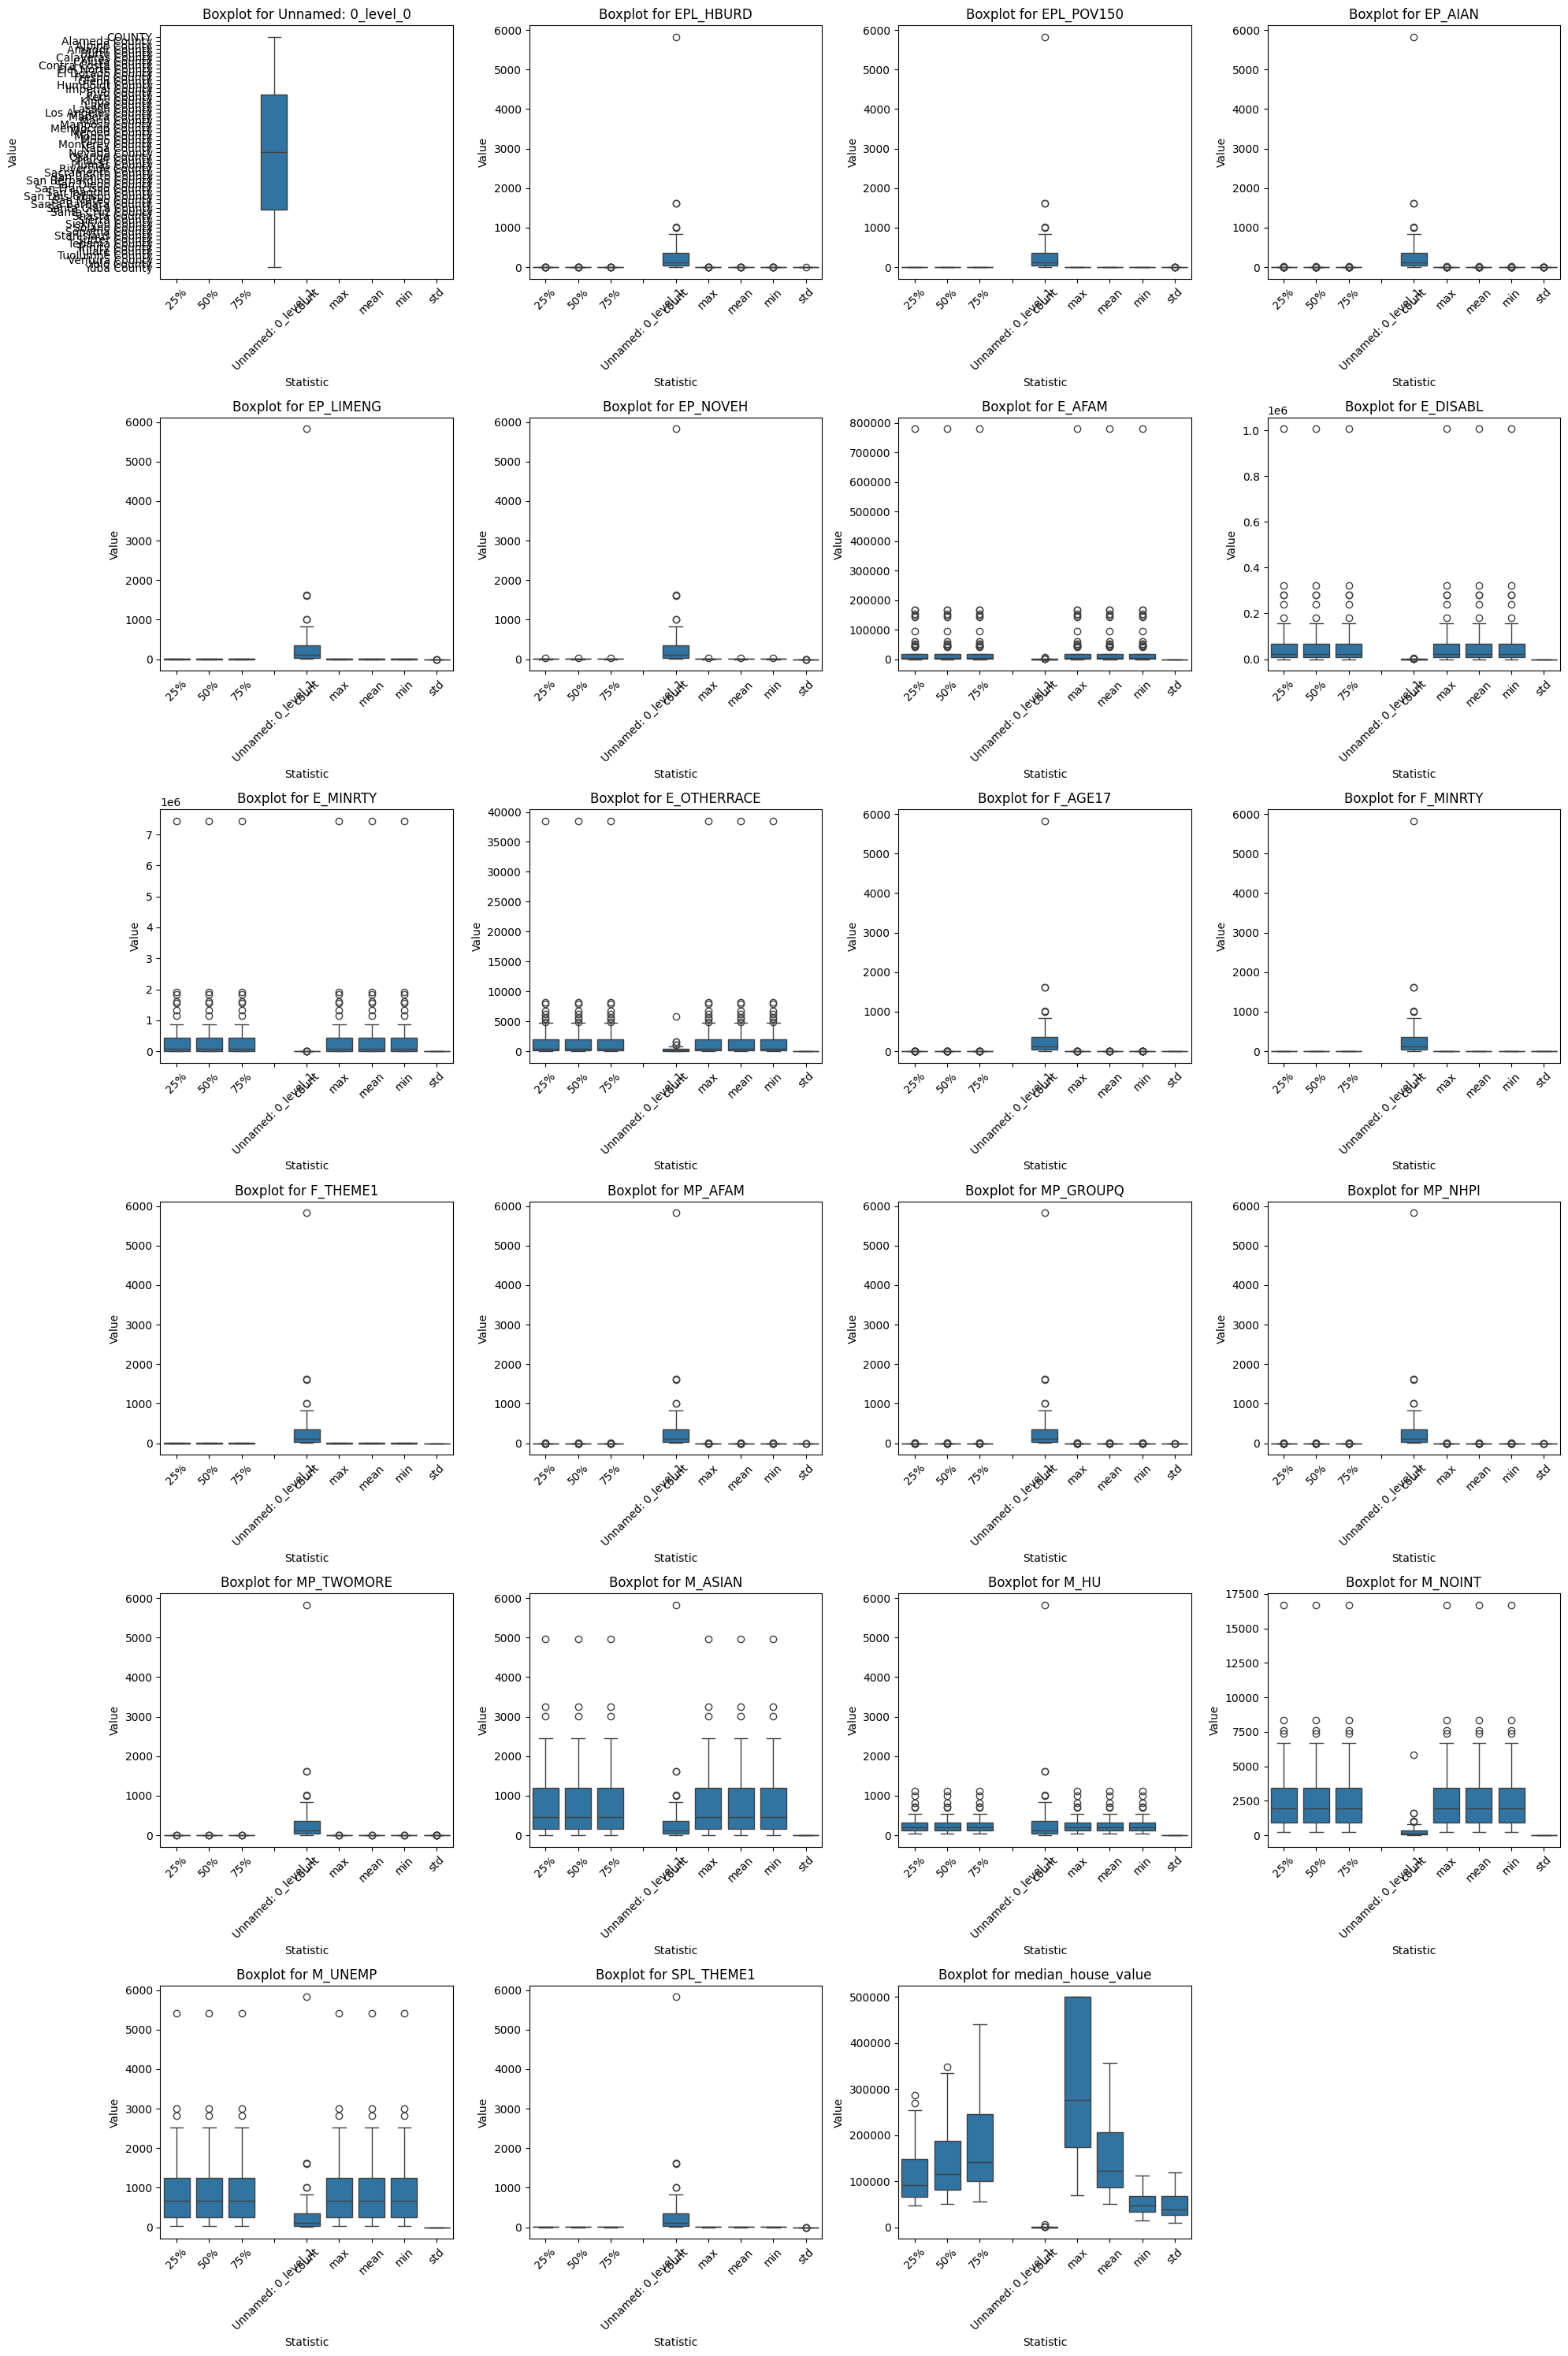

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 加载数据
data = pd.read_csv('https://github.com/jianghan0v0/CASA006-coursework/raw/main/dataset/descriptive_statistics.csv', header=[0, 1]) # 适应多级列索引

# 多级索引转换为长格式
data_long = data.stack(level=0).reset_index(level=1)

# 移除列名称中不需要的字符串
data_long.columns = [col.replace('population_', '') for col in data_long.columns]

# 数据重塑为长格式
data_long = data_long.melt(id_vars=['level_1'], var_name='Statistic', value_name='Value')

# 假设每个统计指标都会生成一个箱形图
filtered_stats = data_long['level_1'].unique()[::7]  # 使用步长为5来选择统计指标

num_stats = len(filtered_stats)
num_cols = 4  # 每行显示4个图形
num_rows = -(-num_stats // num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5))  # 调整子图大小
# 将子图的坐标轴转化为一维数组
axes = axes.flatten() if num_rows > 1 else [axes]
plots_count = 0

for i, stat in enumerate(filtered_stats):
    sns.boxplot(x='Statistic', y='Value', data=data_long[data_long['level_1'] == stat], ax=axes[plots_count])
    axes[plots_count].set_title(f'Boxplot for {stat}')
    # 设置刻度位置和标签
    axes[plots_count].set_xticks(range(len(data_long['Statistic'].unique())))
    axes[plots_count].set_xticklabels(data_long['Statistic'].unique(), rotation=45)
    plots_count += 1

# 现在隐藏所有剩余的子图
for j in range(plots_count, num_cols * num_rows):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


According to the results above, we can see the data is distributed symmetrically, the mean is a good representation of the center of the data.
Moreover, std (standard deviation), an indicator of the degree of dispersion of the data, variables with a larger standard deviation show greater variation between data points, which may indicate that the variable has a greater influence on the results.

Then following study we will use the mean value for each county.

# 3. PCA
In an effort to unveil the underlying social factors that affect the distribution of medical resources across California, we have undertaken a comprehensive Principal Component Analysis (PCA). This analysis distilled 153 variables into 12 principal components (PCs), each highlighting different aspects of societal influence. Our approach has been to visualize these components spatially, placing the abstract into the tangible realm of geography.

Here we explore the relationships between socioeconomic indicators, housing, age, population data, and healthcare resources across 58 counties in California. The goal is to identify the main components that capture the most variance in the data and reduce the dimensionality for further statistical modeling and insights into social inequality issues.

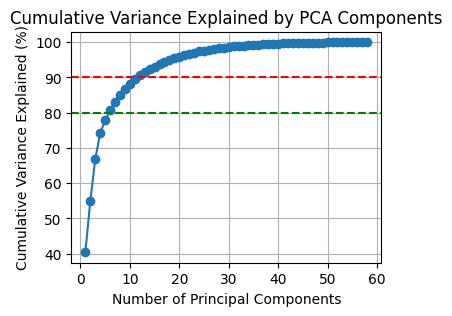

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'explained_variance' contains the variance explained by each PCA component
explained_variance_path = 'https://github.com/jianghan0v0/CASA006-coursework/raw/main/dataset/explained_variance.csv'  # Adjust the path if needed
explained_variance = pd.read_csv(explained_variance_path)

# Calculate cumulative variance
cumulative_variance_explained = np.cumsum(explained_variance) * 100

# Create a plot to visualize cumulative variance explained by the components
plt.figure(figsize=(4, 3))
plt.plot(range(1, len(cumulative_variance_explained) + 1), cumulative_variance_explained, marker='o')
plt.title('Cumulative Variance Explained by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained (%)')
plt.grid(True)
plt.axhline(y=90, color='r', linestyle='--')  # Line for 90% variance
plt.axhline(y=80, color='g', linestyle='--')  # Line for 80% variance
plt.show()

The cumulative variance explained by each pc is illustrated in the plot above. This visualization is crucial for deciding how many components to retain based on how much total variance they explain:

From the plot and the cumulative percentages:
· About 90% of the total variance is explained by the first 12 components(red dashed line).
· About 80% of the total variance is explained by the first 6 components(green dashed line).

Therefore, the follows we will try to get 13 variables by PCA to meet 90% explanation rate.

In [12]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Data loading
cleaned_mean_data_path = 'https://github.com/jianghan0v0/CASA006-coursework/raw/main/dataset/cleaned_descriptive_statistics.csv'
cleaned_mean_data = pd.read_csv(cleaned_mean_data_path)

# Assuming the dataset is structured with features and an identifier column
# Remove non-feature columns if present, adjust column names as necessary
X = cleaned_mean_data.drop(columns=['County_Name', 'County_Code'])  # Adjust if there are other non-feature columns

# Standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying PCA
pca = PCA(n_components=12)  # Specify 12 components directly
X_pca = pca.fit_transform(X_scaled)

# Explaining variance ratios
explained_variance = pca.explained_variance_ratio_

# Create a DataFrame for the transformed PCA features
pca_columns = ['PC' + str(i) for i in range(1, 13)]
pca_df = pd.DataFrame(X_pca, columns=pca_columns)
print(pca_df.head())


         PC1       PC2        PC3        PC4       PC5       PC6       PC7  \
0   8.761004 -3.725838  -3.558676   2.671906  3.066058 -1.000911 -1.743626   
1 -12.652782 -9.165375  13.565545  16.152832  1.207069  6.164257 -1.718936   
2  -6.214789 -3.798450  -0.044135  -2.917832  3.105931 -0.547880  1.205727   
3  -2.032931  0.302389  -0.906062  -3.911809  1.772470  2.375306 -0.275560   
4  -6.961172 -4.055759  -0.049998  -4.488569 -4.376101 -0.392020 -1.014189   

        PC8       PC9      PC10      PC11      PC12  
0  2.202346 -0.466072 -0.746339  0.722786  0.126159  
1 -2.897049  2.150267 -1.753290 -0.267391 -0.563242  
2  0.222073  3.031404  0.585680  0.927321  0.052860  
3 -1.739562 -0.409557 -0.446273 -1.017797 -0.841073  
4  0.308144  1.898266  0.263616 -1.495352 -0.076219  


In [13]:
# Save the PCA results to a CSV file
output_file_path = '/content/pca_df.csv'
pca_df.to_csv(output_file_path, index=False)
#from google.colab import files
#files.download('/content/pca_df.csv')

Recognizing the complexity and sheer volume of variables, the next strategic move was to apply PCA, a decision born out of the necessity to distill and simplify. PCA would not only reduce dimensionality but also unveil underlying patterns, with the resulting components laying bare the variance and significance wrapped within the original variables.

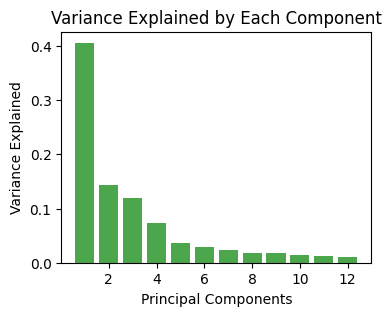

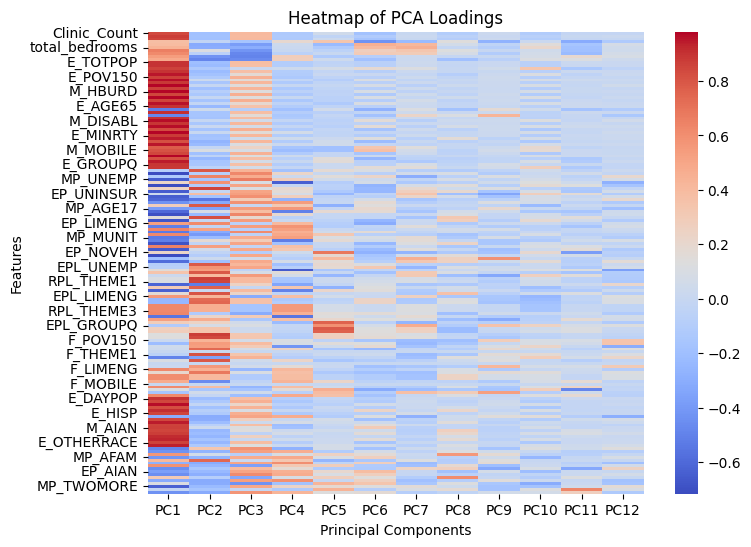

In [14]:
# Visualizing the variance explained by each PCA component
plt.figure(figsize=(4, 3))
plt.bar(range(1, 13), explained_variance, alpha=0.7, color='g')
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained')
plt.title('Variance Explained by Each Component')
plt.show()

# Creating a heatmap of the component loadings to show how original features contribute to components
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_df = pd.DataFrame(loadings, columns=pca_columns, index=X.columns)
plt.figure(figsize=(8, 6))
sns.heatmap(loading_df, cmap='coolwarm', annot=False, cbar=True)
plt.title('Heatmap of PCA Loadings')
plt.xlabel('Principal Components')
plt.ylabel('Features')
plt.show()

In translating numbers into narratives, visualization played a crucial role. The variance explained by PCA components was illustrated through bar graphs, and a heatmap detailed how original features correlated with principal components.

In PCA, each principal component (PC) is a linear combination of the original variables, and the coefficients (or loadings) in these combinations provide insight into the relative influence of each variable on the component. According to the results above, PC1 explaining the most variance within the data and PC10 the least of these 10.

From the heatmap, we mainly analysis the PC1's result. PC1 is highly influenced by Clinic_Count and Hospital_Count, suggesting it represents overall healthcare facility availability.
To decline the number of variables, we build a scree plot map to find percentage variance of interpretation for each principal component in my PCA results.

In [15]:
import pandas as pd

# Load your original dataset
forest_data_path = 'https://github.com/jianghan0v0/CASA006-coursework/raw/main/dataset/cleaned_descriptive.csv'  # 修改为你的文件路径
forest_data = pd.read_csv(forest_data_path)

# List of the top 15 features from the feature importance chart
top_features = [
    'E_LIMENG', 'E_NOHSDP', 'EP_MUNIT', 'EPL_MINRTY', 'E_MOBILE',
    'M_MOBILE', 'E_NOINT', 'E_CROWD', 'E_DISABL', 'M_DISABL',
    'EP_NOVEH', 'E_HH', 'M_MUNIT', 'E_OTHERRACE', 'M_UNINSUR'
]

# Ensuring to include 'facility_total'
top_features.append('facility_total')

# Select only the columns of interest based on top features
selected_data = forest_data[top_features]

# Save the selected data to a new CSV file
selected_data.to_csv('selected_data.csv', index=False)


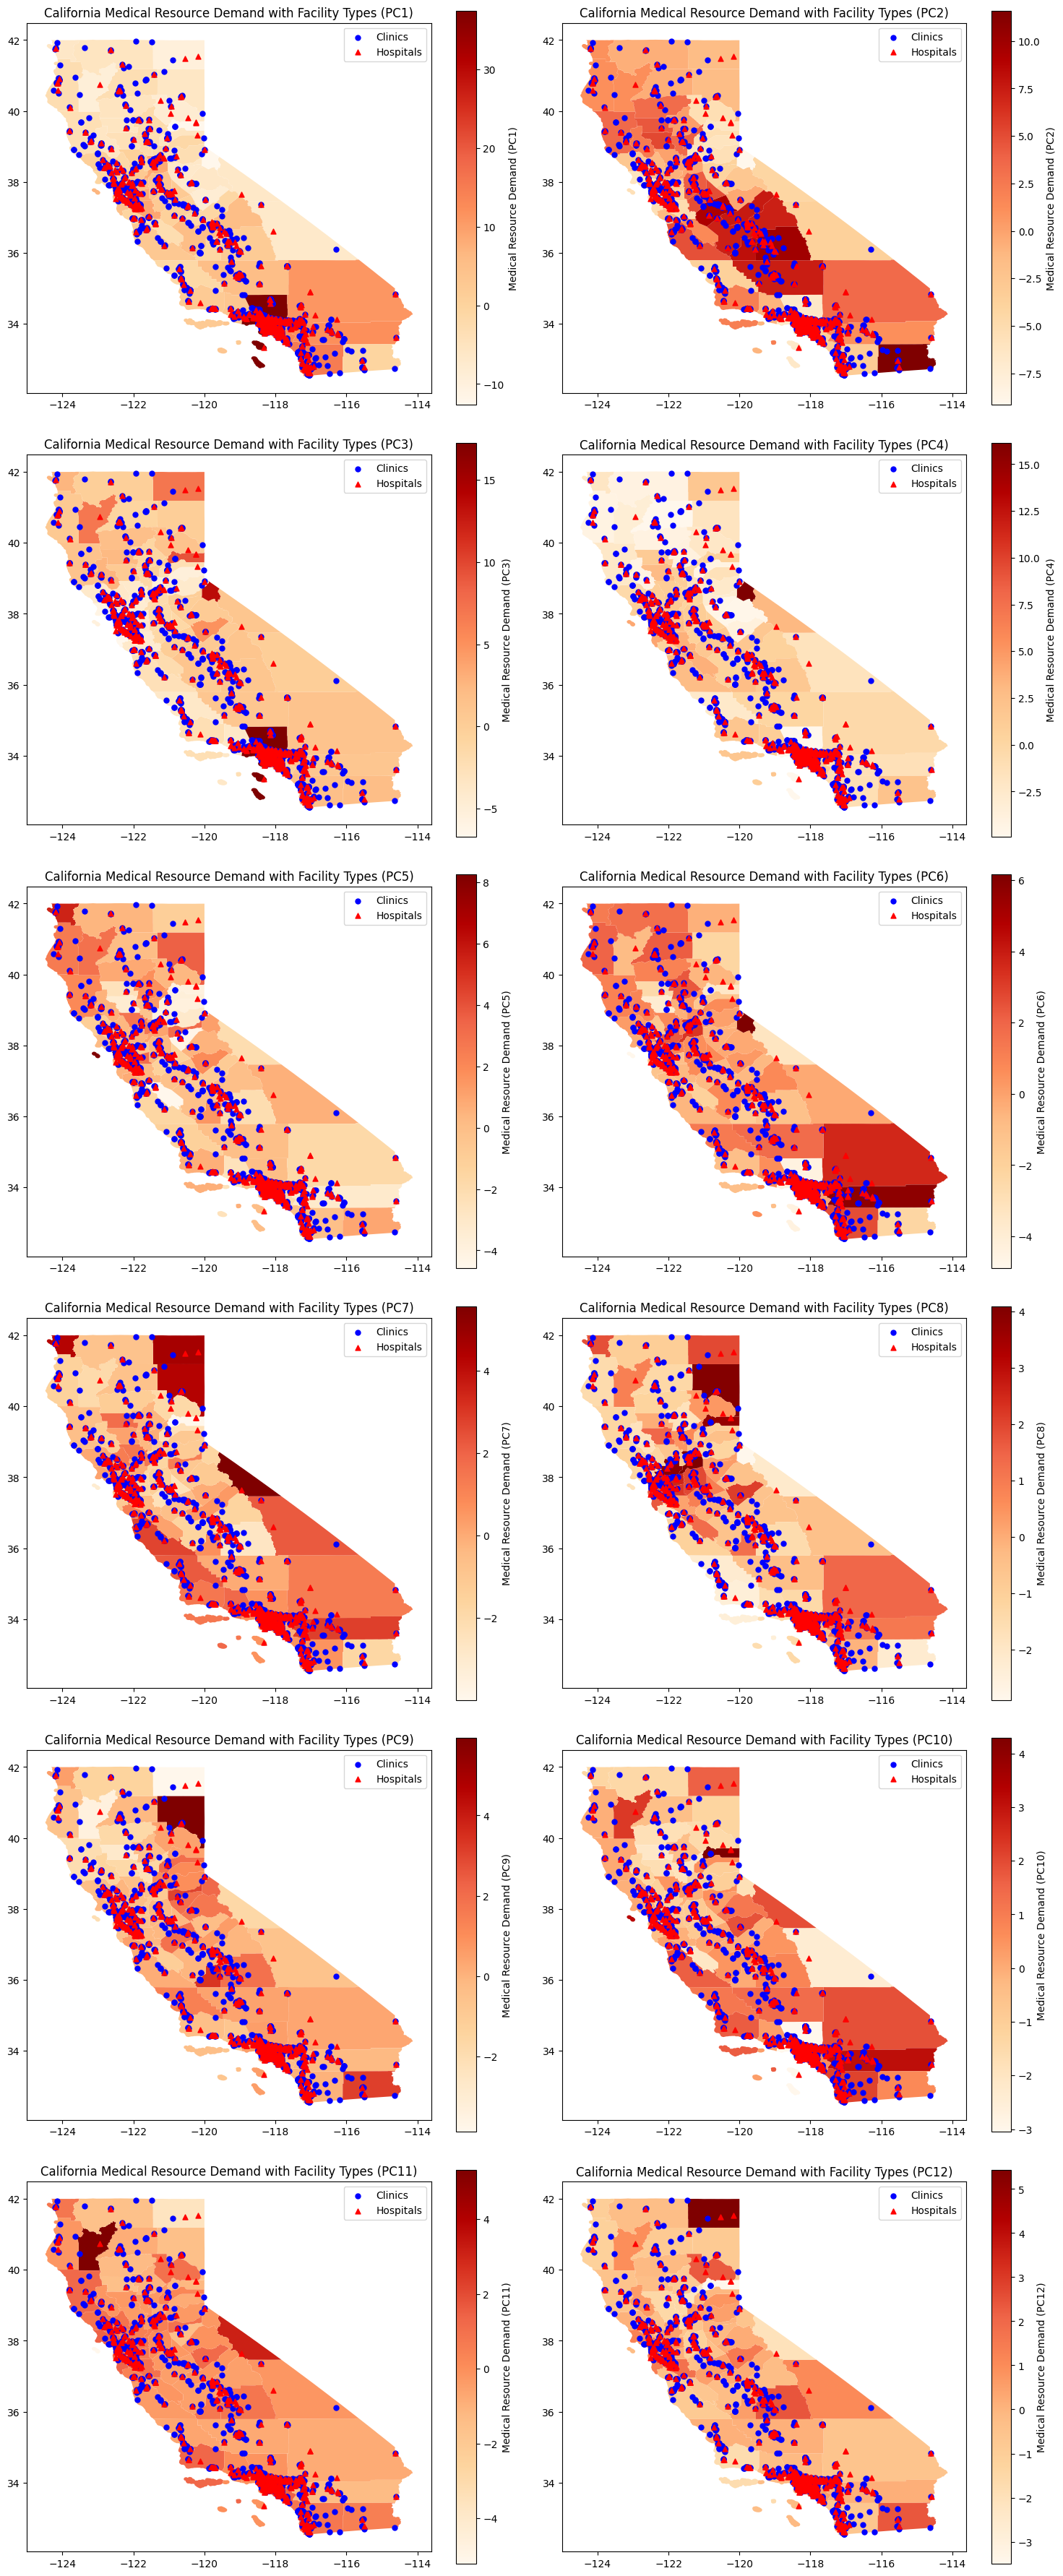

In [16]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# 加载数据
pca_df = pd.read_csv('https://github.com/jianghan0v0/CASA006-coursework/raw/main/dataset/pca_df.csv')
facilities_df = pd.read_csv('https://github.com/jianghan0v0/CASA006-coursework/raw/main/dataset/Facility1.csv')

# 加载加州县界shapefile
counties_shapefile = gpd.read_file('https://github.com/jianghan0v0/CASA006-coursework/raw/main/dataset/ca_county_boundaries/ca_county_boundaries.shp')

# 合并数据
counties_shapefile = counties_shapefile.merge(pca_df, how='left', left_on='NAME', right_on='County_Name')

# 创建医疗设施的GeoDataFrame
facilities_df['geometry'] = [Point(xy) for xy in zip(facilities_df['longitude'], facilities_df['latitude'])]
facilities_gdf = gpd.GeoDataFrame(facilities_df, geometry='geometry')

# 根据设施类型分组绘制医疗设施位置
clinics = facilities_gdf[facilities_gdf['Type'] == 'Clinic']
hospitals = facilities_gdf[facilities_gdf['Type'] == 'Hospital']

# 设置子图布局
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15, 36))  # 6行2列
axes = axes.flatten()  # 将axes数组变平，方便迭代

# 为每个PC值绘制一个地图
for i in range(1, 13):
    ax = axes[i-1]
    pc_column = f'PC{i}'
    base = counties_shapefile.plot(ax=ax, column=pc_column, cmap='OrRd', legend=True, legend_kwds={'label': f"Medical Resource Demand (PC{i})"})

    # 绘制医疗设施位置
    clinics.plot(ax=ax, markersize=25, color='blue', label='Clinics', marker='o')
    hospitals.plot(ax=ax, markersize=25, color='red', label='Hospitals', marker='^')

    # 设置图例和标题
    ax.legend()
    ax.set_title(f'California Medical Resource Demand with Facility Types (PC{i})')

# 调整子图间距
plt.tight_layout()
plt.show()


The PCA was applied to numerous variables spanning healthcare facility counts (clinics and hospitals), demographic statistics, socioeconomic status, and housing characteristics. The data were standardized before applying PCA to ensure that each variable contributes equally to the analysis.

Utilizing GeoPandas for spatial data manipulation and Matplotlib for visualization, we have mapped the distribution of the 12 principal components derived from PCA onto the counties of California. Medical facilities, categorized as clinics and hospitals, have been overlaid onto this map to provide a clear visual correlation between facility location and the social factors represented by each PC.



## 3.2 Results
The series of maps generated reveal a diverse landscape of social phenomena as they relate to medical resources. The gradation of colors—from light to dark—reflects the intensity of each PC within the counties. The deeper the hue, the more pronounced the feature represented by the principal component.

For instance, the first principal component (PC1) encapsulate factors like population density or economic status, while another PC might be more representative of variables such as the distribution of age demographics or prevalence of chronic diseases.

The goal of this spatial analysis is twofold. Firstly, to provide a visual interpretation of complex multi-dimensional data that can inform public health strategies. Secondly, to facilitate the identification of areas where the interplay between social factors and medical resource distribution is most critical.

# 4. Random Forest

With the rapid growth of medical demand, accurate prediction of medical resource allocation in different regions has become a key issue in public health planning. This report presents a predictive analysis of healthcare resources (total number of hospitals and clinics) across California counties using random forest models, with the aim of providing data support for public health decisions and helping to uncover possible resource allocation imbalances.

## 4.1 Decision Tree & Random Forest
The study used detailed socioeconomic and demographic data from 58 counties in California that covered 10 variables calculated by PCA method above, which is created by 153 variables relevant to public health. First, we preprocessed the data, including data cleaning and removing irrelevant features. We then trained the random forest model on 80% of the data and evaluated the model's performance on the remaining 20% of the test data. The goal of the model training is to predict facility_total, the total number of health facilities in each county. Random forests reduce the risk of overfitting and provide more reliable predictions than a single decision tree model.

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 加载数据
forest_data_pca_path = 'https://github.com/jianghan0v0/CASA006-coursework/raw/main/dataset/pca_df.csv'  # 修改为你的文件路径
forest_data_pca = pd.read_csv(forest_data_pca_path)

# 分割数据为训练集和测试集
X = forest_data_pca.drop(columns=['facility_total','County_Name'])
y = forest_data_pca['facility_total']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 决策树模型
decision_tree = DecisionTreeRegressor(random_state=42)
decision_tree.fit(X_train, y_train)
y_pred_dt = decision_tree.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

# 随机森林模型
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# 特征重要性
feature_importance_rf = random_forest.feature_importances_

# 输出结果
print("Decision tree model MSE:", mse_dt)
print("Decision tree model R²:", r2_dt)
print("Random Forest Models MSE:", mse_rf)
print("Random Forest Models R²:", r2_rf)
#print("Feature Importance of Random Forest Models :", feature_importance_rf)


Decision tree model MSE: 30218.083333333332
Decision tree model R²: -23.31563242155849
Random Forest Models MSE: 1130.2782583333335
Random Forest Models R²: 0.09049722444189878


Unfortunately, the results of decision tree and random forest model with 10 variables produced by PCA method are not satisfactory. This may be because the data itself does not contain enough information to make accurate predictions, and the number of hospitals the model reports back to is indeed a very flat variable. Also, PCA preserves only the most important components and may oversimplify the model, making it unable to capture the complex relationships that determine the target variables.

Therefore, we try to use all 153 variables relevant to public health to rebuild that model.

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 加载数据
forest_data_path = 'https://github.com/jianghan0v0/CASA006-coursework/raw/main/dataset/cleaned_descriptive.csv'  # 修改为你的文件路径
forest_data = pd.read_csv(forest_data_path)

# 分割数据为训练集和测试集
X = forest_data.drop(columns='facility_total')
y = forest_data['facility_total']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 决策树模型
decision_tree = DecisionTreeRegressor(random_state=42)
decision_tree.fit(X_train, y_train)
y_pred_dt = decision_tree.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

# 随机森林模型
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# 特征重要性
feature_importance_rf = random_forest.feature_importances_

# 输出结果
print("Decision tree model MSE:", mse_dt)
print("Decision tree model R²:", r2_dt)
print("Random Forest Models MSE:", mse_rf)
print("Random Forest Models R²:", r2_rf)
#print("Feature Importance of Random Forest Models :", feature_importance_rf)


Decision tree model MSE: 780.25
Decision tree model R²: 0.3721550110362941
Random Forest Models MSE: 256.3312666666667
Random Forest Models R²: 0.7937375183705401


## 4.2 Feature Importance

The path led to the application of a random forest model, leveraging its robustness to predict the distribution of healthcare facilities. The model illuminated the weight of various socioeconomic indicators, painting a picture of the landscape of healthcare accessibility across California.
According to the feature importance graph above, we obtain the top 15 variables of contribution value; And this scatter plot compares the predicted values of the model to the actual data values. Ideally, the points will be snugly on the diagonal, which indicates that the predicted value matches the actual value. The graph shows that most predictions are relatively accurate, despite some bias.


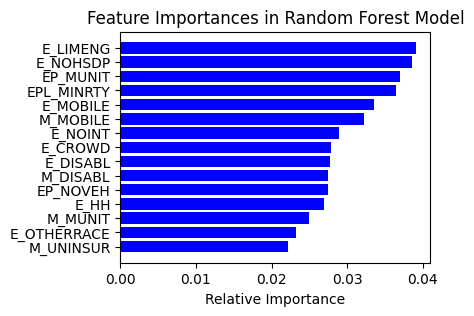

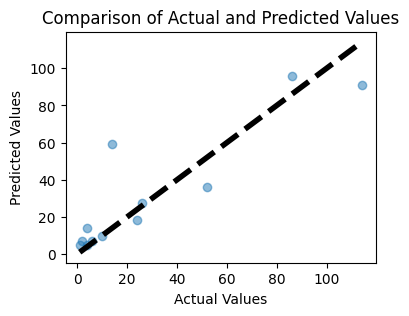

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 计算随机森林模型的特征重要性
feature_importance_rf = random_forest.feature_importances_
features = X.columns
indices = np.argsort(feature_importance_rf)[::-1]

# 特征重要性可视化
plt.figure(figsize=(4, 3))
plt.title('Feature Importances in Random Forest Model')
plt.barh(range(len(indices[:15])), feature_importance_rf[indices[:15]], color='b', align='center')
plt.yticks(range(len(indices[:15])), [features[i] for i in indices[:15]])
plt.xlabel('Relative Importance')
plt.gca().invert_yaxis()  # Invert axis to have the most important at the top
plt.show()

# 预测值与实际值比较图
plt.figure(figsize=(4, 3))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.show()


## 4.3 Feature Importance Analysis
This part outlines the significance of various socioeconomic and demographic indicators on the distribution of medical resources across different cities, as derived from a random forest model trained on the 2020 Social Vulnerability Index (SVI) data.

Key words analysis:

* E_MOBILE: Prevalence of mobile homes, hinting at unique healthcare needs.
* E_LIMENG: Limited English proficiency, impacting access to healthcare.
* E_NOHSDP: Low educational attainment, possibly leading to reduced medical resources.
* EP_MUNIT: Housing density, affecting medical resource distribution.
* EPL_MINRTY: Racial and ethnic makeup, with minorities showing greater medical needs.

The above factors underscore the multifaceted nature of social vulnerability concerning medical resource distribution. The correlation between mobile home prevalence and medical resources could reflect underlying economic or systemic challenges in these communities. Language proficiency is critical for effective communication between healthcare providers and patients, affecting healthcare access and outcomes.

Furthermore, education often correlates with health literacy, which is crucial for navigating healthcare systems. Housing density may affect disease transmission rates and access to healthcare facilities. Lastly, racial and ethnic minorities may face various systemic barriers to accessing healthcare, reflecting a broader societal issue of inequality.


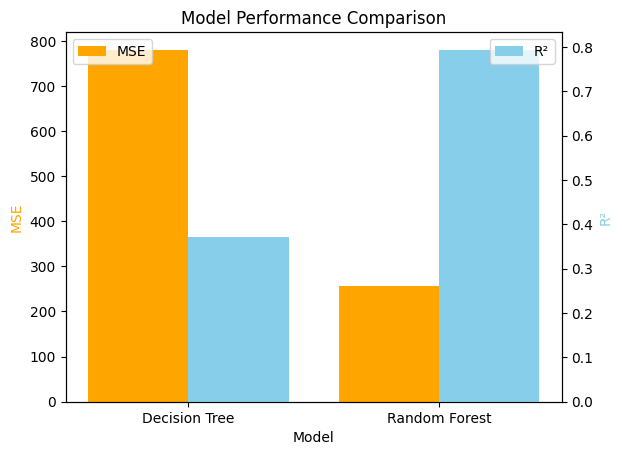

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# 模型性能数据
models = ['Decision Tree', 'Random Forest']
mse_values = [780.25, 256.331]
r2_values = [0.372, 0.794]

fig, ax1 = plt.subplots()

# 创建一个双y轴图形
ax2 = ax1.twinx()

# 绘制MSE条形图
mse_bars = ax1.bar(np.arange(len(models)) - 0.2, mse_values, 0.4, label='MSE', color='orange')

# 绘制R²条形图
r2_bars = ax2.bar(np.arange(len(models)) + 0.2, r2_values, 0.4, label='R²', color='skyblue')

# 设置图表标题和图例
ax1.set_xlabel('Model')
ax1.set_ylabel('MSE', color='orange')
ax2.set_ylabel('R²', color='skyblue')
plt.title('Model Performance Comparison')
ax1.set_xticks(np.arange(len(models)))
ax1.set_xticklabels(models)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# 自动调整x轴标签，避免重叠
plt.xticks(rotation=45)

# 显示图形
plt.show()


According to the model running results, we can see that the performance of the random forest model is significantly better than that of the decision tree model, explaining about 79% of the data variability, indicating that its prediction ability is relatively good.

The feature importance analysis of the random forest model reveals the most influential factors for the prediction of the number of medical facilities. Based on the importance score, we can find the variables that have the greatest impact on the model's predictive output.

Therefore, next, I drew the feature importance graph to more intuitively show the contribution of each feature to the model prediction results.

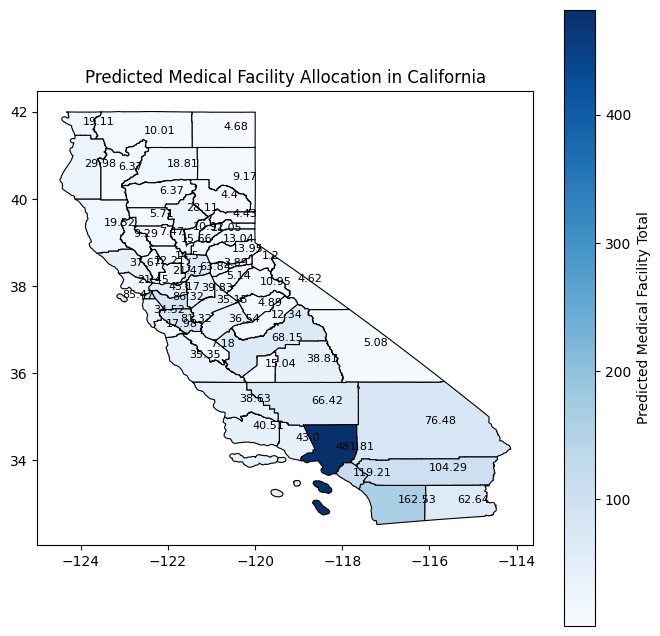

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 加载数据
forest_data1_path = 'https://github.com/jianghan0v0/CASA006-coursework/raw/main/dataset/cleaned_descriptive1.csv'  # 修改为你的文件路径
forest_data1 = pd.read_csv(forest_data1_path)

county_names = forest_data1[['County_Name']].copy()

# 分割数据为训练集和测试集
X = forest_data1.drop(columns=['facility_total','County_Name'])
y = forest_data1['facility_total']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 决策树模型
decision_tree = DecisionTreeRegressor(random_state=42)
decision_tree.fit(X_train, y_train)
y_pred_dt = decision_tree.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

# 随机森林模型
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# 使用随机森林模型对整个数据集进行预测（确保不包括County_Name列）
y_pred_full = random_forest.predict(X)

# 将预测结果添加到county_names的副本DataFrame中
county_names['predicted_facility_total'] = y_pred_full

# 使用副本DataFrame（现在包含预测结果）与地理信息合并
county_map = counties_shapefile.merge(county_names, how='left', left_on='NAME', right_on='County_Name')

# 创建预测的医疗资源分布地图
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
county_map.plot(ax=ax, column='predicted_facility_total', cmap='Blues', legend=True,
                        legend_kwds={'label': "Predicted Medical Facility Total"}, edgecolor='black', linewidth=0.8)
# 在每个县上添加预测数值标签
for idx, row in county_map.iterrows():
    # 获得每个形状的代表性点（大致是中心）
    repr_point = row['geometry'].representative_point().coords[:]
    # 在代表性点位置上添加文本标签
    plt.text(repr_point[0][0], repr_point[0][1], str(row['predicted_facility_total']), fontsize=8)

plt.title('Predicted Medical Facility Allocation in California')
plt.show()


By the prediction map, now we want to build a map that could clearly show the difference between predicted facility number and the reality number.

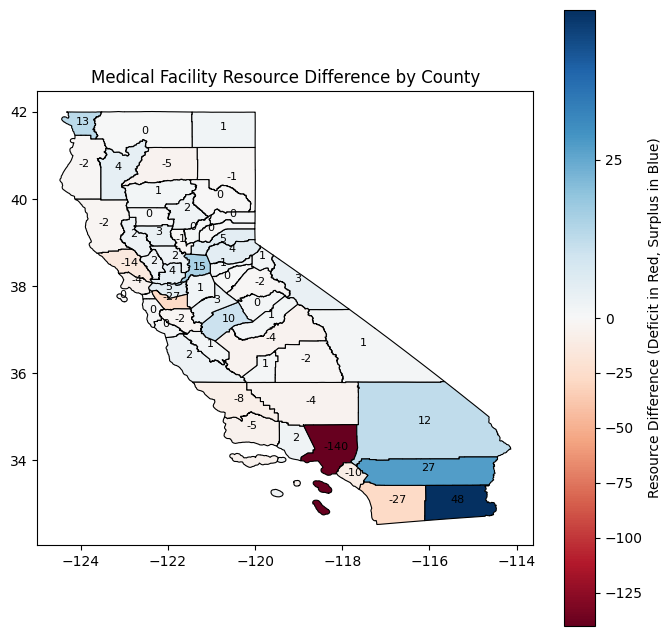

In [24]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# 加载数据
forest_data1_path = 'https://github.com/jianghan0v0/CASA006-coursework/raw/main/dataset/cleaned_descriptive1.csv'
forest_data1 = pd.read_csv(forest_data1_path)

# 分割数据为训练集和测试集
X = forest_data1.drop(columns=['facility_total', 'County_Name'])
y = forest_data1['facility_total']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 随机森林模型
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)
y_pred_full = random_forest.predict(X)

# 创建一个新的DataFrame来保存预测和真实值
results_df = pd.DataFrame({
    'County_Name': forest_data1['County_Name'],
    'facility_total': y,
    'predicted_facility_total': y_pred_full
})

# 计算资源差异
results_df['resource_difference'] = results_df['predicted_facility_total'] - results_df['facility_total']

# 合并地理数据和结果数据
county_map = counties_shapefile.merge(results_df, how='left', on='County_Name')
norm = TwoSlopeNorm(vmin=county_map['resource_difference'].min(),
                     vcenter=0,
                     vmax=county_map['resource_difference'].max())

# 创建一个基于资源差异的地图
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
county_map.plot(ax=ax, column='resource_difference',
                cmap='RdBu', norm=norm, legend=True,
                legend_kwds={'label': "Resource Difference (Deficit in Red, Surplus in Blue)"},
                edgecolor='black', linewidth=0.8)

ax.set_title('Medical Facility Resource Difference by County')

# 在每个县上添加预测数值标签
for idx, row in county_map.iterrows():
    repr_point = row['geometry'].representative_point().coords[:]
    plt.text(repr_point[0][0], repr_point[0][1], f"{int(row['resource_difference']):d}", fontsize=8, ha='center')

plt.show()


Here is a map showing medical resource differences by county in California. If the area needs more hospitals, it will appear red, and if it has more medical resources than expected, it will appear blue.

# 5. Conclusion

In conclusion, this research distilled 153 variables into 12 principal components to analyze California's medical resource allocation, revealing significant disparities. The advanced predictive models employed demonstrated the Random Forest's superiority in accuracy. Spatial visualizations further identified areas with urgent healthcare needs, underscoring the role of socio-economic factors in resource distribution. Ultimately, the findings point towards the multi-layered nature of healthcare provision and social equity. The disparities in resource distribution underscore the necessity for policy interventions that are cognizant of underlying social determinants. As the state looks towards enhancing its public health infrastructure, this research offers a data-driven approach to support decision-making processes, aiming to bolster a more equitable and efficient allocation of medical resources in California.

# Reading List

DeMaio, P. (2009). Bike-sharing: History, impacts, models of provision, and future. Journal of Public Transportation, 12(4), 41-56.

Fishman, E. (2013). Bikeshare: A review of recent literature. Transport Reviews, 33(3), 303-327.

Lin, J. R., & Yang, T. H. (2011). Strategic design of public bicycle sharing systems with service level constraints. Transportation Research Part E: Logistics and Transportation Review, 47(2), 284-294.

Chelma, E., Meunier, D., & Wolfler, A. (2011). The OBIS Handbook: A guide to understanding and evaluating bike-sharing systems. European Cyclists' Federation.